In [19]:
# import pickle
# import numpy as np

In [20]:
# files = ["data/cifar10/train/data_batch_1.bin","data/cifar10/train/data_batch_2.bin","data/cifar10/train/data_batch_3.bin","data/cifar10/train/data_batch_4.bin","data/cifar10/train/data_batch_5.bin"]
# # files = ["cifar-10-batches-py/data_batch_1.bin","cifar-10-batches-py/data_batch_2.bin","cifar-10-batches-py/data_batch_3.bin","cifar-10-batches-py/data_batch_4.bin","cifar-10-batches-py/data_batch_5.bin"]

In [21]:
# x_train = np.zeros((50000, 3072))
# y_train = np.zeros((50000))

In [22]:
# import numpy as np

# # Ensure file paths are correct
# files = [
#     "data/cifar10/train/data_batch_1.bin",
#     "data/cifar10/train/data_batch_2.bin",
#     "data/cifar10/train/data_batch_3.bin",
#     "data/cifar10/train/data_batch_4.bin",
#     "data/cifar10/train/data_batch_5.bin"
# ]

# # Initialize arrays
# x_train = np.zeros((50000, 3072), dtype=np.float32)
# y_train = np.zeros((50000,), dtype=np.int32)

# # Function to load a single batch
# def load_cifar_batch(filename):
#     with open(filename, 'rb') as file:
#         data = np.frombuffer(file.read(), dtype=np.uint8)
#     labels = data[::3073]
#     images = data[1:].reshape(-1, 3072).astype(np.float32) / 255.0
#     return images, labels

# # Load data
# for i, file in enumerate(files):
#     start = i * 10000
#     end = (i + 1) * 10000
#     images, labels = load_cifar_batch(file)
#     x_train[start:end, :] = images
#     y_train[start:end] = labels
#     print(f"Loaded {file}")

# print("Data loaded successfully.")


ValueError: cannot reshape array of size 30729999 into shape (3072)

In [ ]:
# x_test = np.zeros((10000,3072))
# y_test = np.zeros((10000))

In [ ]:
# x_train.shape

(50000, 3072)

In [ ]:

# file = "data/cifar10/test/test_batch.bin"
# with open(file, 'rb') as fo:
#     dict = pickle.load(fo, encoding='bytes')
 
#     x_test[0:10000,:] = dict[b'data']
#     y_test[0:10000] = dict[b'labels']
    
#     fo.close()

UnpicklingError: invalid load key, '\x03'.

In [ ]:
# def unpickle(fileName):
#     '''
#     Description: retrieve data from CIFAR-10 Pickles
#     Params: fileName = filename to unpickle
#     Outputs: Unpickled Dict
#     '''
#     with open(fileName, 'rb') as f:
#         dict = pickle.load(f, encoding='bytes')
#     return dict


# def merge_batches():
    
#     for i in range(0,5):
#         fileName = "../input/cifar10/data_batch_" + str(i + 1)
#         data = unpickle(fileName)
#         if i == 0:
#             features = data[b'data']
#             labels = np.array(data[b'labels'])
#         else:
#             features = np.append(features, data[b'data'], axis=0)
#             labels = np.append(labels, data[b'labels'], axis=0)
#     return features, labels


# def one_hot_encode(data):
#     '''
#     Description: Encode Target Label IDs to one hot vector of size L where L is the
#     number of unique labels
#     Params: data = list of label IDs
#     Outputs: List of One Hot Vectors
#     '''
#     one_hot = np.zeros((data.shape[0], 10))
#     one_hot[np.arange(data.shape[0]), data] = 1
#     return one_hot


# def normalize(data):
#     '''
#     Description: Normalize Pixel values
#     Params: list of Image Pixel Features
#     Outputs: Normalized Image Pixel Features
#     '''
#     return data / 255.0


# def preprocess():
#     '''
#     Description: helper function to load and preprocess CIFAR-10 training data batches
#     Params: num_to_load = number of batches of CIFAR-10 to load and merge
#     Outputs: Pre-processed CIFAR-10 image features and labels
#     '''
#     X, y = merge_batches()
#     X = normalize(X)
#     X = X.reshape(-1, 3072, 1)
#     y = one_hot_encode(y)
#     y = y.reshape(-1, 10, 1)
#     return X, y


# def dataset_split(X, y, ratio=0.9):
#     '''
#     Description: helper function to split training data into training and validation
#     Params: X=image features
#             y=labels
#             ratio = ratio of training data from total data
#     Outputs: training data (features and labels) and validation data
#     '''
#     split = int(ratio * X.shape[0])
#     indices = np.random.permutation(X.shape[0])
#     training_idx, val_idx = indices[:split], indices[split:]
#     X_train, X_val = X[training_idx, :], X[val_idx, :]
#     y_train, y_val = y[training_idx, :], y[val_idx, :]
#     print("Records in Training Dataset", X_train.shape[0])
#     print("Records in Validation Dataset", X_val.shape[0])
#     return X_train, y_train, X_val, y_val


# def sigmoid(out):
#     '''
#     Description: Sigmoid Activation
#     Params: out = a list/matrix to perform the activation on
#     Outputs: Sigmoid activated list/matrix
#     '''
#     return 1.0 / (1.0 + np.exp(-out))


# def delta_sigmoid(out):
#     '''
#     Description: Derivative of Sigmoid Activation
#     Params: out = a list/matrix to perform the activation on
#     Outputs: Delta(Sigmoid) activated list/matrix
#     '''
#     return sigmoid(out) * (1 - sigmoid(out))

# def SigmoidCrossEntropyLoss(a, y):

#         return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

In [ ]:
# class DNN(object):
#     '''
#             Description: Class to define the Deep Neural Network
#     '''

#     def __init__(self, sizes):
#         '''
#         Description: initialize the biases and weights using a Gaussian
#         distribution with mean 0, and variance 1.
#         Biases are not set for 1st layer that is the input layer.
#         Params: sizes = a list of size L; where L is the number of layers
#                         in the deep neural network and each element of list contains
#                         the number of neuron in that layer.
#                         first and last elements of the list corresponds to the input
#                         layer and output layer respectively
#                         intermediate layers are hidden layers.
#         '''
#         self.num_layers = len(sizes)
#         # setting appropriate dimensions for weights and biases
#         self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
#         self.weights = [np.random.randn(y, x)
#                         for x, y in zip(sizes[:-1], sizes[1:])]

#     def forwardPropagation(self, x):
#         '''
#         Description: Forward Passes an image feature matrix through the Deep Neural
#                                  Network Architecture.
#         Params: x = Image Features
#         Outputs: 2 lists which stores outputs and activations at every layer,
#                  1st list is non-activated and 2nd list is activated
#                  The last element of the 2nd list corresponds to the scores against
#                  10 labels in the dataset.
#         '''
#         activation = x
#         activations = [x]  # list to store activations for every layer
#         outs = []  # list to store out vectors for every layer
#         for b, w in zip(self.biases, self.weights):
#             out = np.dot(w, activation) + b
#             outs.append(out)
#             activation = sigmoid(out)
#             activations.append(activation)
#         return outs, activations

#     def get_batch(self, X, y, batch_size):
#         '''
#         Description: A data iterator for batching of image features and labels
#         Params: X, y = lists of Features and corresponding labels, these lists
#                                    have to be batched.
#                 batch_size =  size of the batch
#         Outputs: a batch of image features and labels of size = batch_size
#         '''
#         for batch_idx in range(0, X.shape[0], batch_size):
#             batch = zip(X[batch_idx:batch_idx + batch_size],
#                         y[batch_idx:batch_idx + batch_size])
#             yield batch

#     def train(self, X, y,x_val,y_val ,batch_size=100, learning_rate=0.01, epochs=100):
#         '''
#         Description: Batch-wise trains image features against corresponding labels.
#                      The weights and biases of the neural network are updated through
#                      backpropagation on batches using SGD
#                      del_b and del_w are of same size as all the weights and biases
#                      of all the layers. del_b and del_w contains the gradients which
#                      are used to update weights and biases
#         Params: X, y = lists of training features and corresponding labels
#                 batch_size =  size of the batch
#                 learning_rate = eta; controls the size of changes in weights & biases
#                 epochs = no. of times to iterate of the whole data
#         '''
#         n_batches = X.shape[0] // batch_size
#         for j in range(epochs):
#             batch_iter = self.get_batch(X, y, batch_size)
#             #print(type(batch_iter))
#             for i in range(n_batches):
#                 batch = next(batch_iter)
#                 # same shape as self.biases
#                 del_b = [np.zeros(b.shape) for b in self.biases]
#                 # same shape as self.weights
#                 del_w = [np.zeros(w.shape) for w in self.weights]
#                 for batch_X, batch_y in batch:
#                     # accumulate all the bias and weight gradients
#                     loss, delta_del_b, delta_del_w = self.backPropagation(
#                         batch_X, batch_y)
#                     del_b = [db + ddb for db, ddb in zip(del_b, delta_del_b)]
#                     del_w = [dw + ddw for dw, ddw in zip(del_w, delta_del_w)]
#             # update weight and biases by multiplying ratio learning rate and batch_size
#             # multiplied with the accumulated gradients(partial derivatives)
#             # calculate change in weight(delta) and biases and update weight
#             # with the changes
#             self.weights = [w - (learning_rate / batch_size)
#                             * delw for w, delw in zip(self.weights, del_w)]
#             self.biases = [b - (learning_rate / batch_size)
#                            * delb for b, delb in zip(self.biases, del_b)]
#             acc_val = self.eval(x_val,y_val)
#             acc_train = self.eval(X,y)
            
#             print("\nEpoch %d complete\t training accuracy: %f\n"%(j, acc_train))
#             print("\nEpoch %d complete\t validation accuracy: %f\n"%(j, acc_val))
#             print("\nEpoch %d complete\t taining Loss: %f\n"%(j, loss))

#     def backPropagation(self, x, y):

#         del_b = [np.zeros(b.shape) for b in self.biases]
#         del_w = [np.zeros(w.shape) for w in self.weights]


#         outs, activations = self.forwardPropagation(x)

#         loss = SigmoidCrossEntropyLoss(activations[-1],y)

#         delta_cost = activations[-1] - y

#         delta = delta_cost
#         del_b[-1] = delta
#         del_w[-1] = np.dot(delta, activations[-2].T)


#         for l in range(2, self.num_layers):
#             out = outs[-l]
#             delta_activation = delta_sigmoid(out)
            
#             delta = np.dot(self.weights[-l + 1].T, delta) * delta_activation
#             del_b[-l] = delta
#             del_w[-l] = np.dot(delta, activations[-l - 1].T)
#         return (loss, del_b, del_w)

#     def eval(self, X, y):
#         '''
#         Description: Based on trained(updated) weights and biases, predict a label and compare
#                      it with original label and calculate accuracy
#         Params: X, y = a data example from validation dataset (image features, labels)
#         Outputs: accuracy of prediction
#         '''
#         count = 0
#         for x, _y in zip(X, y):
#             outs, activations = self.forwardPropagation(x)
#             # postion of maximum value is the predicted label
#             if np.argmax(activations[-1]) == np.argmax(_y):
#                 count += 1
        
        
#         #print("Accuracy: %f" % ((float(count) / X.shape[0]) * 100))
#         return float(count) / X.shape[0] * 100

#     def predict(self, X):
#         '''
#         Description: Based on trained(updated) weights and biases, predict a label for an
#                                  image which does not have a label.
#         Params: X = list of features of unknown images
#         Outputs: list containing the predicted label for the corresponding unknown image
#         '''
#         labels = unpickle("cifar-10-batches-py/batches.meta")["label_names"]
#         preds = np.array([])
#         for x in X:
#             outs, activations = self.feedforward(x)
#             preds = np.append(preds, np.argmax(activations[-1]))
#         preds = np.array([labels[int(p)] for p in preds])
#         return preds

In [ ]:
# X, y = preprocess()
# X_train, y_train, X_val, y_val = dataset_split(X, y)
    
# model = DNN([3072,30, 20, 10])  # initialize the model
# model.train(X_train, y_train,X_val, y_val, epochs=5)  # train the model


FileNotFoundError: [Errno 2] No such file or directory: '../input/cifar10/data_batch_1'

In [3]:
# import pickle
# import numpy as np
# import os

# # Load CIFAR-10 batch data
# def load_cifar10_batch(filename):
#     with open(filename, 'rb') as f:
#         datadict = pickle.load(f, encoding='bytes')
#         X = datadict[b'data']
#         Y = datadict[b'labels']
#         X = X.reshape(10000, 3, 32, 32).astype("float")
#         Y = np.array(Y)
#         return X, Y

# # Load all CIFAR-10 data
# def load_cifar10(ROOT):
#     xs = []
#     ys = []
#     for b in range(1, 6):
#         f = os.path.join(ROOT, 'data_batch_%d' % (b,))
#         X, Y = load_cifar10_batch(f)
#         xs.append(X)
#         ys.append(Y)
#     Xtr = np.concatenate(xs)
#     Ytr = np.concatenate(ys)
#     del X, Y
#     Xte, Yte = load_cifar10_batch(os.path.join(ROOT, 'test_batch'))
#     return Xtr, Ytr, Xte, Yte

# ROOT = './cifar-10-batches-py'
# X_train, y_train, X_test, y_test = load_cifar10(ROOT)

# # Fully connected neural network class
# class FullyConnectedNN:
#     def __init__(self, input_size, hidden_size, output_size):
#         self.W1 = np.random.randn(input_size, hidden_size) * 0.01
#         self.b1 = np.zeros((1, hidden_size))
#         self.W2 = np.random.randn(hidden_size, output_size) * 0.01
#         self.b2 = np.zeros((1, output_size))

#     def relu(self, Z):
#         return np.maximum(0, Z)

#     def softmax(self, Z):
#         expZ = np.exp(Z - np.max(Z))
#         return expZ / expZ.sum(axis=1, keepdims=True)

#     def forward(self, X):
#         self.Z1 = np.dot(X, self.W1) + self.b1
#         self.A1 = self.relu(self.Z1)
#         self.Z2 = np.dot(self.A1, self.W2) + self.b2
#         self.A2 = self.softmax(self.Z2)
#         return self.A2

#     def compute_loss(self, Y, Y_hat):
#         m = Y.shape[0]
#         log_likelihood = -np.log(Y_hat[range(m), Y])
#         loss = np.sum(log_likelihood) / m
#         return loss

#     def backward(self, X, Y, Y_hat):
#         m = X.shape[0]
#         dZ2 = Y_hat
#         dZ2[range(m), Y] -= 1
#         dZ2 /= m

#         dW2 = np.dot(self.A1.T, dZ2)
#         db2 = np.sum(dZ2, axis=0, keepdims=True)

#         dA1 = np.dot(dZ2, self.W2.T)
#         dZ1 = dA1 * (self.Z1 > 0)

#         dW1 = np.dot(X.T, dZ1)
#         db1 = np.sum(dZ1, axis=0, keepdims=True)

#         self.W1 -= learning_rate * dW1
#         self.b1 -= learning_rate * db1
#         self.W2 -= learning_rate * dW2
#         self.b2 -= learning_rate * db2

#     def compute_accuracy(self, X, Y):
#         Y_hat = self.forward(X)
#         predictions = np.argmax(Y_hat, axis=1)
#         accuracy = np.mean(predictions == Y)
#         return accuracy

#     def train(self, X, Y, epochs=1000, learning_rate=0.01):
#         for epoch in range(epochs):
#             # Forward pass
#             Y_hat = self.forward(X)
#             loss = self.compute_loss(Y, Y_hat)
            
#             # Backward pass
#             self.backward(X, Y, Y_hat)
            
#             # Compute accuracy
#             accuracy = self.compute_accuracy(X, Y)
            
#             # Print loss and accuracy for each epoch
#             print(f'Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# # Preprocess data
# X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
# X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# # Hyperparameters
# input_size = 3072  # 32*32*3
# hidden_size = 100
# output_size = 10
# learning_rate = 0.01
# epochs = 2000

# # Initialize and train the model
# model = FullyConnectedNN(input_size, hidden_size, output_size)
# model.train(X_train, y_train, epochs, learning_rate)

# # Predict on the test set
# y_pred = np.argmax(model.forward(X_test), axis=1)
# accuracy = np.mean(y_pred == y_test)
# print(f'Test Accuracy: {accuracy:.4f}')


Epoch [1], train_loss: 2.3039, val_loss: 2.3039, val_acc: 0.0880
Epoch [2], train_loss: 2.3038, val_loss: 2.3038, val_acc: 0.0889
Epoch [3], train_loss: 2.3036, val_loss: 2.3036, val_acc: 0.0889
Epoch [4], train_loss: 2.3035, val_loss: 2.3035, val_acc: 0.0908
Epoch [5], train_loss: 2.3034, val_loss: 2.3033, val_acc: 0.0928
Epoch [6], train_loss: 2.3032, val_loss: 2.3032, val_acc: 0.0938
Epoch [7], train_loss: 2.3031, val_loss: 2.3031, val_acc: 0.0966
Epoch [8], train_loss: 2.3029, val_loss: 2.3029, val_acc: 0.0985
Epoch [9], train_loss: 2.3028, val_loss: 2.3028, val_acc: 0.0988
Epoch [10], train_loss: 2.3027, val_loss: 2.3026, val_acc: 0.1027
Epoch [11], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1046
Epoch [12], train_loss: 2.3024, val_loss: 2.3024, val_acc: 0.1070
Epoch [13], train_loss: 2.3023, val_loss: 2.3022, val_acc: 0.1087
Epoch [14], train_loss: 2.3021, val_loss: 2.3021, val_acc: 0.1099
Epoch [15], train_loss: 2.3020, val_loss: 2.3020, val_acc: 0.1107
Epoch [16], train_l

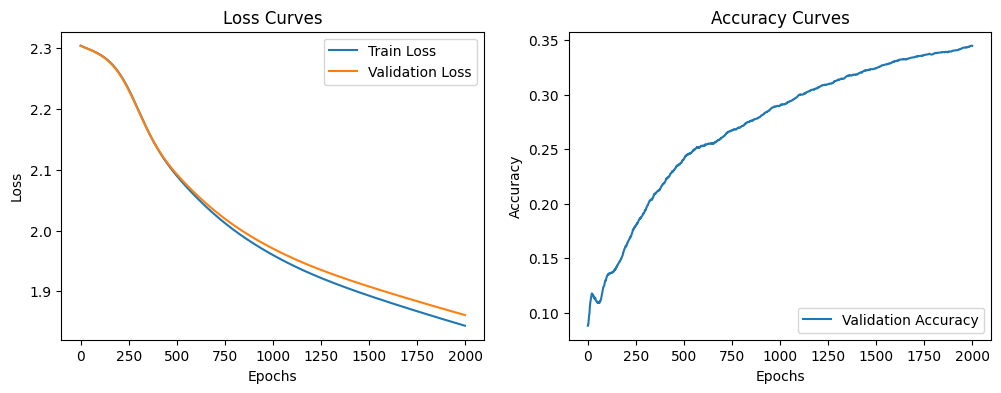

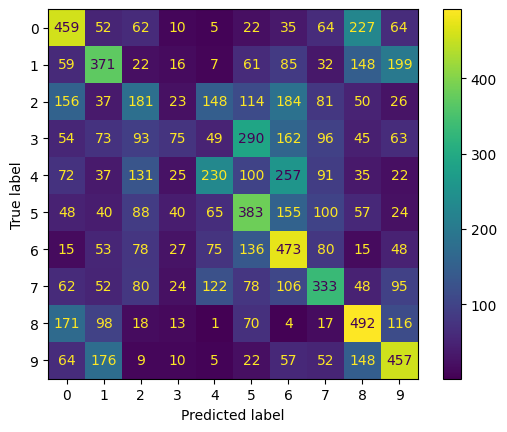

In [32]:
# import pickle
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Load CIFAR-10 batch data
# def load_cifar10_batch(filename):
#     with open(filename, 'rb') as f:
#         datadict = pickle.load(f, encoding='bytes')
#         X = datadict[b'data']
#         Y = datadict[b'labels']
#         X = X.reshape(10000, 3, 32, 32).astype("float")
#         Y = np.array(Y)
#         return X, Y

# # Load all CIFAR-10 data
# def load_cifar10(ROOT):
#     xs = []
#     ys = []
#     for b in range(1, 6):
#         f = os.path.join(ROOT, 'data_batch_%d' % (b,))
#         X, Y = load_cifar10_batch(f)
#         xs.append(X)
#         ys.append(Y)
#     Xtr = np.concatenate(xs)
#     Ytr = np.concatenate(ys)
#     del X, Y
#     Xte, Yte = load_cifar10_batch(os.path.join(ROOT, 'test_batch'))
#     return Xtr, Ytr, Xte, Yte

# ROOT = './cifar-10-batches-py'
# X_train, y_train, X_test, y_test = load_cifar10(ROOT)

# # Fully connected neural network class
# class FullyConnectedNN:
#     def __init__(self, input_size, hidden_size, output_size):
#         self.W1 = np.random.randn(input_size, hidden_size) * 0.01
#         self.b1 = np.zeros((1, hidden_size))
#         self.W2 = np.random.randn(hidden_size, output_size) * 0.01
#         self.b2 = np.zeros((1, output_size))

#     def relu(self, Z):
#         return np.maximum(0, Z)

#     def softmax(self, Z):
#         expZ = np.exp(Z - np.max(Z))
#         return expZ / expZ.sum(axis=1, keepdims=True)

#     def forward(self, X):
#         self.Z1 = np.dot(X, self.W1) + self.b1
#         self.A1 = self.relu(self.Z1)
#         self.Z2 = np.dot(self.A1, self.W2) + self.b2
#         self.A2 = self.softmax(self.Z2)
#         return self.A2

#     def compute_loss(self, Y, Y_hat):
#         m = Y.shape[0]
#         log_likelihood = -np.log(Y_hat[range(m), Y])
#         loss = np.sum(log_likelihood) / m
#         return loss

#     def backward(self, X, Y, Y_hat):
#         m = X.shape[0]
#         dZ2 = Y_hat
#         dZ2[range(m), Y] -= 1
#         dZ2 /= m

#         dW2 = np.dot(self.A1.T, dZ2)
#         db2 = np.sum(dZ2, axis=0, keepdims=True)

#         dA1 = np.dot(dZ2, self.W2.T)
#         dZ1 = dA1 * (self.Z1 > 0)

#         dW1 = np.dot(X.T, dZ1)
#         db1 = np.sum(dZ1, axis=0, keepdims=True)

#         self.W1 -= self.learning_rate * dW1
#         self.b1 -= self.learning_rate * db1
#         self.W2 -= self.learning_rate * dW2
#         self.b2 -= self.learning_rate * db2

#     def compute_accuracy(self, X, Y):
#         Y_hat = self.forward(X)
#         predictions = np.argmax(Y_hat, axis=1)
#         accuracy = np.mean(predictions == Y)
#         return accuracy

#     def train(self, X_train, Y_train, X_val, Y_val, epochs=1000, learning_rate=0.01):
#         self.learning_rate = learning_rate
#         train_losses = []
#         val_losses = []
#         val_accuracies = []

#         for epoch in range(epochs):
#             # Forward pass
#             Y_hat_train = self.forward(X_train)
#             train_loss = self.compute_loss(Y_train, Y_hat_train)
            
#             # Backward pass
#             self.backward(X_train, Y_train, Y_hat_train)

#             # Compute validation loss and accuracy
#             Y_hat_val = self.forward(X_val)
#             val_loss = self.compute_loss(Y_val, Y_hat_val)
#             val_accuracy = self.compute_accuracy(X_val, Y_val)
            
#             # Store losses and accuracy
#             train_losses.append(train_loss)
#             val_losses.append(val_loss)
#             val_accuracies.append(val_accuracy)
            
#             # Print losses and accuracy for each epoch
#             print(f'Epoch [{epoch + 1}], train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_accuracy:.4f}')
        
#         return train_losses, val_losses, val_accuracies

# # Preprocess data
# X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
# X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# # Split training data into training and validation sets
# split_index = int(0.8 * X_train.shape[0])
# X_val, y_val = X_train[split_index:], y_train[split_index:]
# X_train, y_train = X_train[:split_index], y_train[:split_index]

# # Hyperparameters
# input_size = 3072  # 32*32*3
# hidden_size = 100
# output_size = 10
# learning_rate = 0.01
# epochs = 2000

# # Initialize and train the model
# model = FullyConnectedNN(input_size, hidden_size, output_size)
# train_losses, val_losses, val_accuracies = model.train(X_train, y_train, X_val, y_val, epochs, learning_rate)

# # Predict on the test set
# y_pred = np.argmax(model.forward(X_test), axis=1)
# accuracy = np.mean(y_pred == y_test)
# print(f'Test Accuracy: {accuracy:.4f}')

# # Plot loss and accuracy curves
# epochs_range = range(epochs)
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, train_losses, label='Train Loss')
# plt.plot(epochs_range, val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(loc='upper right')
# plt.title('Loss Curves')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Accuracy Curves')
# plt.show()

# # Confusion Matrix with CIFAR-10 labels
# cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_labels)
# disp.plot()
# plt.show()


Epoch [1], train_loss: 2.0521, val_loss: 2.0500, val_acc: 0.2575
Epoch [2], train_loss: 2.0169, val_loss: 1.9350, val_acc: 0.3044
Epoch [3], train_loss: 1.9408, val_loss: 1.8696, val_acc: 0.3404
Epoch [4], train_loss: 1.8736, val_loss: 1.8219, val_acc: 0.3569
Epoch [5], train_loss: 1.7575, val_loss: 1.7829, val_acc: 0.3700
Epoch [6], train_loss: 1.6739, val_loss: 1.7470, val_acc: 0.3830
Epoch [7], train_loss: 1.9021, val_loss: 1.7303, val_acc: 0.3890
Epoch [8], train_loss: 1.5523, val_loss: 1.7005, val_acc: 0.3974
Epoch [9], train_loss: 1.5798, val_loss: 1.6739, val_acc: 0.4161
Epoch [10], train_loss: 1.4987, val_loss: 1.6564, val_acc: 0.4172
Epoch [11], train_loss: 1.8886, val_loss: 1.6425, val_acc: 0.4237
Epoch [12], train_loss: 1.7728, val_loss: 1.6325, val_acc: 0.4306
Epoch [13], train_loss: 1.5759, val_loss: 1.6128, val_acc: 0.4341
Epoch [14], train_loss: 1.6252, val_loss: 1.6089, val_acc: 0.4303
Epoch [15], train_loss: 1.5344, val_loss: 1.6080, val_acc: 0.4302
Epoch [16], train_l

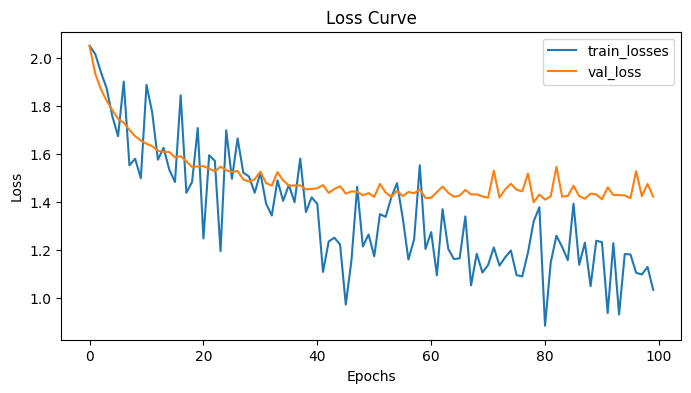

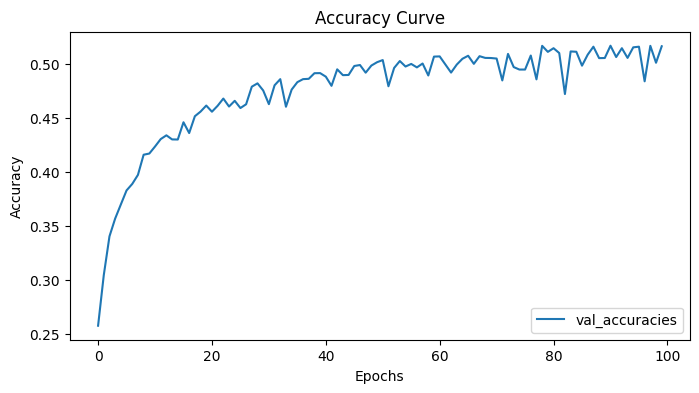

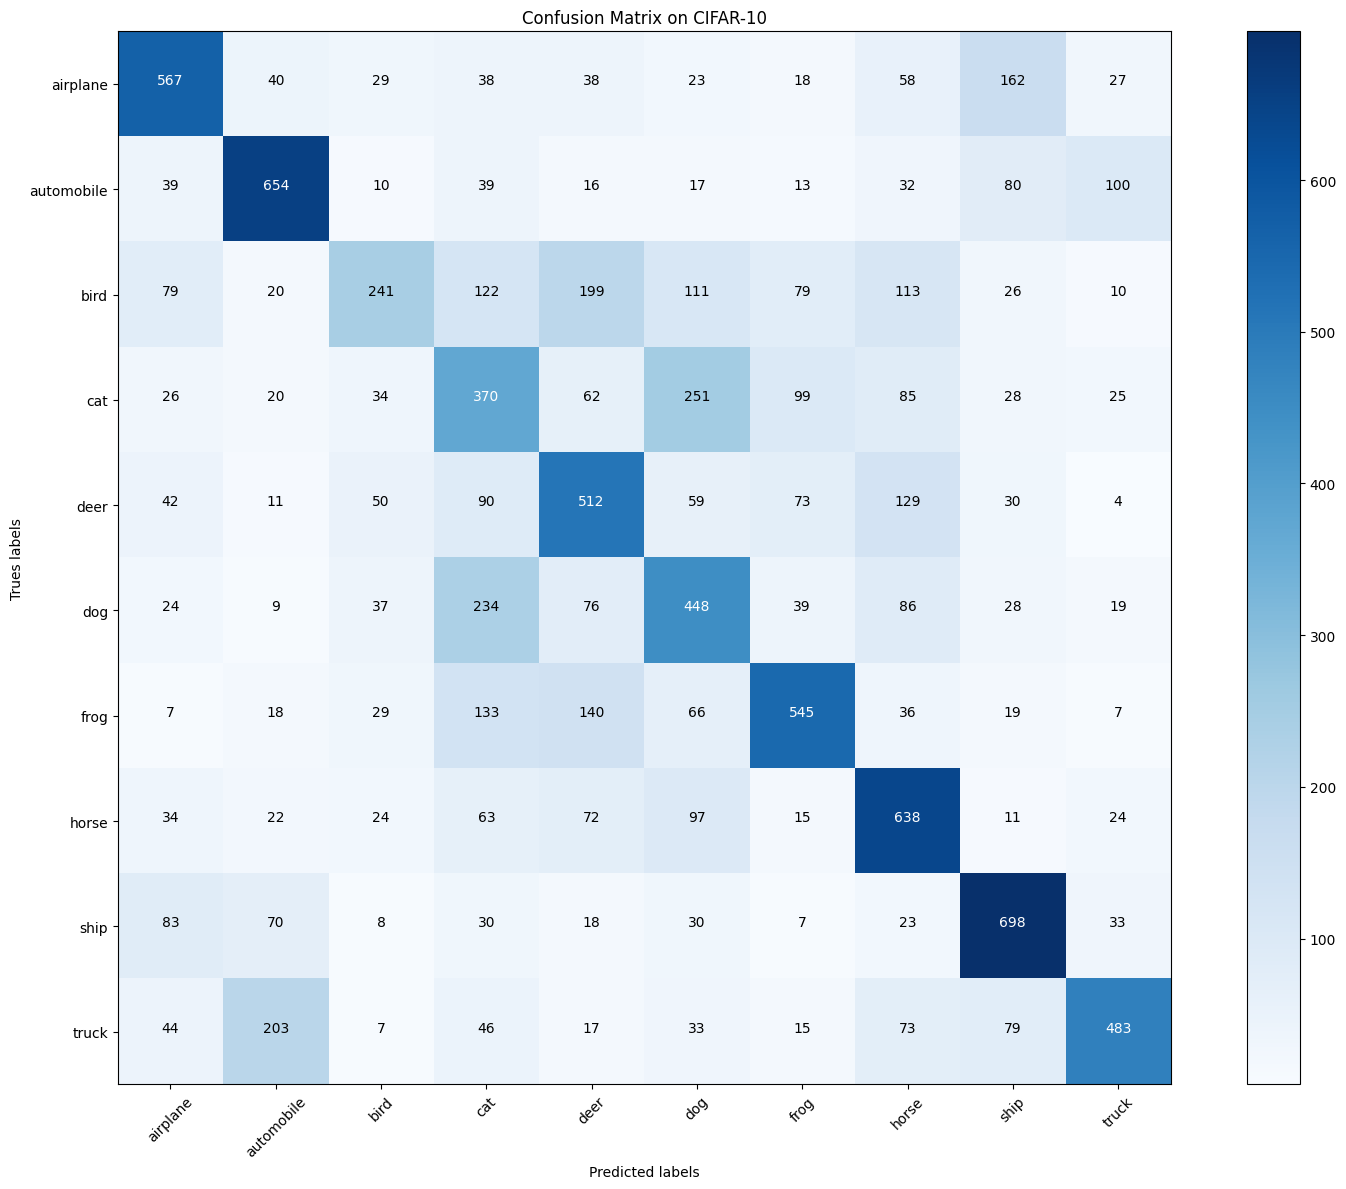

In [2]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

# 加载 CIFAR-10 批次数据
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

# 加载所有 CIFAR-10 数据
def load_cifar10(ROOT):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b,))
        X, Y = load_cifar10_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_cifar10_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

ROOT = './cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10(ROOT)

# 全连接神经网络类
class FullyConnectedNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[0]
        log_likelihood = -np.log(Y_hat[range(m), Y])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, X, Y, Y_hat):
        m = X.shape[0]
        dZ2 = Y_hat
        dZ2[range(m), Y] -= 1
        dZ2 /= m

        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)

        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def compute_accuracy(self, X, Y):
        Y_hat = self.forward(X)
        predictions = np.argmax(Y_hat, axis=1)
        accuracy = np.mean(predictions == Y)
        return accuracy

    def train(self, X_train, Y_train, X_val, Y_val, epochs=300, learning_rate=0.01):
        self.learning_rate = learning_rate
        train_losses = []
        val_losses = []
        val_accuracies = []

        for epoch in range(epochs):
            # 打乱训练数据
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            Y_train = Y_train[indices]

            # 小批量梯度下降
            for start_idx in range(0, X_train.shape[0], batch_size):
                end_idx = min(start_idx + batch_size, X_train.shape[0])
                X_batch = X_train[start_idx:end_idx]
                Y_batch = Y_train[start_idx:end_idx]

                # 前向传播
                Y_hat_train = self.forward(X_batch)
                train_loss = self.compute_loss(Y_batch, Y_hat_train)
                
                # 反向传播
                self.backward(X_batch, Y_batch, Y_hat_train)

            # 每个 epoch 结束后计算验证集上的损失和准确率
            Y_hat_val = self.forward(X_val)
            val_loss = self.compute_loss(Y_val, Y_hat_val)
            val_accuracy = self.compute_accuracy(X_val, Y_val)
            
            # 存储损失和准确率
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # 打印每个 epoch 的损失和准确率
            print(f'Epoch [{epoch + 1}], train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_accuracy:.4f}')
        
        return train_losses, val_losses, val_accuracies

# 预处理数据
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# 将训练数据分成训练集和验证集
split_index = int(0.8 * X_train.shape[0])
X_val, y_val = X_train[split_index:], y_train[split_index:]
X_train, y_train = X_train[:split_index], y_train[:split_index]

# 超参数
input_size = 3072  # 32*32*3
hidden_size = 100
output_size = 10
learning_rate = 0.01
epochs = 100
batch_size = 64

# 初始化并训练模型
model = FullyConnectedNN(input_size, hidden_size, output_size)
train_losses, val_losses, val_accuracies = model.train(X_train, y_train, X_val, y_val, epochs, learning_rate)

# 在测试集上进行预测
y_pred = np.argmax(model.forward(X_test), axis=1)
accuracy = np.mean(y_pred == y_test)
print(f'测试集准确率: {accuracy:.4f}')

# 绘制损失曲线
epochs_range = range(epochs)
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label='train_losses')
plt.plot(epochs_range, val_losses, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve')
plt.show()

# 绘制准确率曲线
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, val_accuracies, label='val_accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')
plt.show()


# 计算混淆矩阵
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, title='Confusion Matrix on CIFAR-10', cmap=plt.cm.Blues):
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Trues labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

# CIFAR-10 标签
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 计算并绘制混淆矩阵
cm = compute_confusion_matrix(y_test, y_pred, len(cifar10_labels))
plot_confusion_matrix(cm, classes=cifar10_labels)


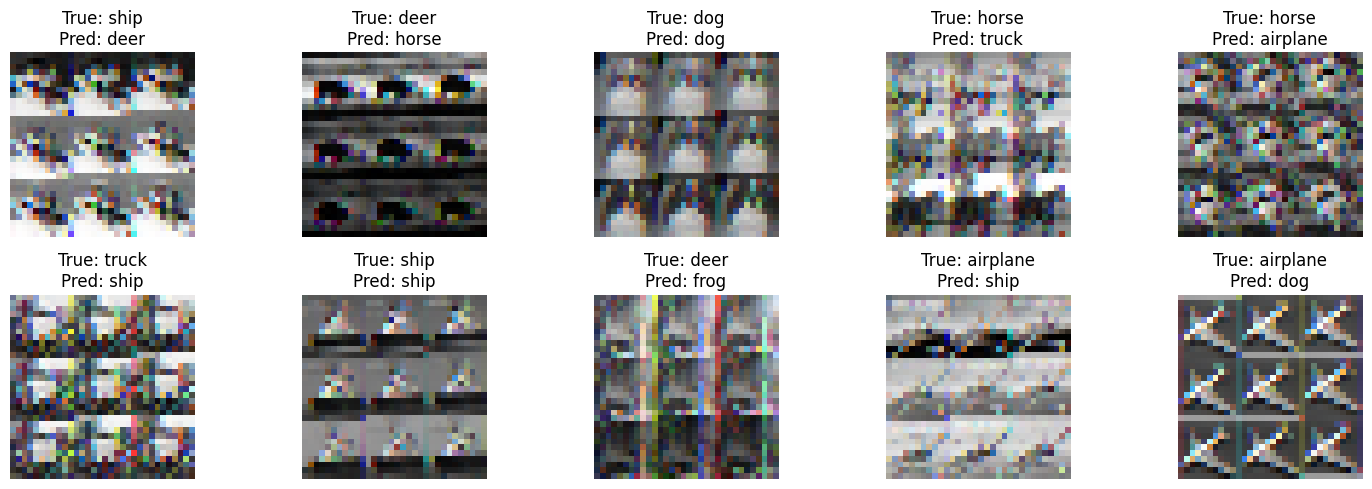

In [7]:
# 随机选择一些验证集中的图像
num_samples = 10
indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[indices]
sample_labels = y_val[indices]

# 进行预测
sample_predictions = np.argmax(model.forward(sample_images), axis=1)

# CIFAR-10 标签
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 绘制图像及其真实标签和预测标签
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    img = sample_images[i].reshape(32, 32, 3)
    img = (img * 255).astype(np.uint8)  # 将图像恢复到原始像素值范围
    plt.imshow(img)
    plt.title(f'True: {cifar10_labels[sample_labels[i]]}\nPred: {cifar10_labels[sample_predictions[i]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
